# OverView

BaseModel:https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug<br>
Inferece part: https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta

confirm inferece:https://www.kaggle.com/harininarasimhan/why-not-to-trust-public-lb-visualization


In [1]:
package_paths = [
    '../input/pytorch-image-models-master', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    '../input/FMix-master'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from warmup_scheduler import GradualWarmupScheduler
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from catalyst.data.sampler import BalanceClassSampler
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2


Bad key "text.kerning_factor" on line 4 in
C:\Users\goomo\Anaconda3\envs\tf\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [3]:
CFG = {
    'input_path': '../input/cassava-leaf-disease-classification/',
    'weight_path': '../weight/',
    'version': 'gcp_v2',
    'fold_num': 5,
    'FOLDS': [0,1,2,3,4],
    'seed': 2021,
    'model_arch': 'tf_efficientnet_b4_ns',
    'loss': 'Smoothed Cross Entropy Loss', # reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
    'optimizer': 'Adam',
    'scheduler': 'GradualWarmupScheduler',
    'img_size': 512,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 0, # set 0 if windows 
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'warmup_factor': 10,
    'warmup_epo': 1,
    'tta': 1,
    'used_epochs': [0],
    'weights': [1],
    'used_2class':[6,7,8,9]
}

In [4]:
train = pd.read_csv(CFG['input_path'] + 'train_folds.csv')
train.head()

image_id  label  kfold
0  1000015157.jpg      0    2.0
1  1000201771.jpg      3    1.0
2   100042118.jpg      1    1.0
3  1000723321.jpg      1    0.0
4  1000812911.jpg      3    4.0

In [5]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [6]:
submission = pd.read_csv(CFG['input_path'] + 'sample_submission.csv')
submission.head()

image_id  label
0  2216849948.jpg      4

# Helper Functions

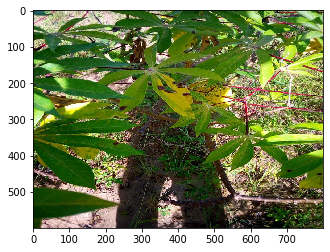

In [7]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img(CFG['input_path'] + 'train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [8]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

In [9]:
class CassavaDataset(Dataset):
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

In [10]:
def prepare_dataloader(df, fold, mode, do_cutmix=True, data_root=CFG['input_path'] + 'train_images/'):
    
    train_ = df[df['kfold']!=fold].reset_index(drop=True)
    valid_ = df[df['kfold']==fold].reset_index(drop=True)
        
    do_cutmix = do_cutmix
    train_ds = CassavaDataset(train_, data_root, transforms=get_test_transforms(mode),
                              output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=do_cutmix)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_test_transforms(mode), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

# Define Train\Validation Image Augmentations

In [11]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, 
    ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

In [12]:
def get_test_transforms(mode):
    if mode == 0:
        return Compose([
                Resize(height=CFG['img_size'], width=CFG['img_size'], p=1.0),
                Transpose(p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.0)
    elif mode == 1:
        return Compose([
                RandomResizedCrop(CFG['img_size'], CFG['img_size']),
                Transpose(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.)
    elif mode == 2:
        return Compose([
                RandomResizedCrop(CFG['img_size'], CFG['img_size']),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.)
    else:
        return Compose([
                RandomResizedCrop(CFG['img_size'], CFG['img_size']),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.)

# Model

In [13]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

# Main Loop

In [14]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [15]:
def prepare_dataloader(df, fold, mode, do_cutmix=True, data_root=CFG['input_path'] + 'train_images/'):
    
    train_ = df[df['kfold']!=fold].reset_index(drop=True)
    valid_ = df[df['kfold']==fold].reset_index(drop=True)
        
    do_cutmix = do_cutmix
    train_ds = CassavaDataset(train_, data_root, transforms=get_test_transforms(mode),
                              output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=do_cutmix)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_test_transforms(mode), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

In [16]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    total_acc = 0

    for fold in CFG['FOLDS']:

        print('Inference fold {} started'.format(fold))     
        device = torch.device(CFG['device'])
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique()).to(device)
        
        valid_ = train[train['kfold']==fold].reset_index(drop=True)

        print('read model: {}_{}_best'.format(CFG['model_arch'], CFG['version']))
        model.load_state_dict(torch.load(CFG['weight_path'] + '{}_{}_fold_{}_best'.format(CFG['model_arch'], CFG['version'], fold)))

        val_preds = []
        with torch.no_grad():
            for mode in range(CFG['tta']):
                
                valid_ds = CassavaDataset(valid_, (CFG['input_path'] + 'train_images/'), 
                                          transforms=get_test_transforms(mode=mode), output_label=False)

                val_loader = torch.utils.data.DataLoader(
                    valid_ds, 
                    batch_size=CFG['valid_bs'],
                    num_workers=CFG['num_workers'],
                    shuffle=False,
                    pin_memory=False,
                )
                
                val_preds += [1/CFG['tta']*inference_one_epoch(model, val_loader, device)]
    
        val_preds = np.mean(val_preds, axis=0)
        total_acc += (valid_.label.values==np.argmax(val_preds, axis=1)).mean()
        print('fold {} validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values, val_preds)))
        print('fold {} validation accuracy = {:.5f}'.format(fold, (valid_.label.values==np.argmax(val_preds, axis=1)).mean()))

        output_descriptor = val_preds
        output_label = valid_.label.values
        
        data = valid_.copy()
        data['predict_label'] = pd.DataFrame(np.argmax(val_preds, axis=1))  
        for i in range(0,5):
            _label_acc = data[(data['label']==data['predict_label']) & (data['predict_label']==i)].shape[0] /\
                                                                                                data[data['label']==i].shape[0]
            print('label:{} accuracy is {:.5f}'.format(i, _label_acc))

        del model
        torch.cuda.empty_cache()
        
print('Fold Ensemble Accuracy== {:.5f}'.format(total_acc/len(CFG['FOLDS'])))

Inference fold 0 started
read model: tf_efficientnet_b4_ns_gcp_v2_best


100%|██████████| 134/134 [02:00<00:00,  1.11it/s]


fold 0 validation loss = 0.36142
fold 0 validation accuracy = 0.89136
label:0 accuracy is 0.63761
label:1 accuracy is 0.77397
label:2 accuracy is 0.77358
label:3 accuracy is 0.98024
label:4 accuracy is 0.75388
Inference fold 1 started
read model: tf_efficientnet_b4_ns_gcp_v2_best


100%|██████████| 134/134 [01:56<00:00,  1.15it/s]


fold 1 validation loss = 0.37023
fold 1 validation accuracy = 0.88785
label:0 accuracy is 0.61927
label:1 accuracy is 0.80365
label:2 accuracy is 0.80084
label:3 accuracy is 0.96731
label:4 accuracy is 0.74806
Inference fold 2 started
read model: tf_efficientnet_b4_ns_gcp_v2_best


100%|██████████| 134/134 [02:00<00:00,  1.12it/s]


fold 2 validation loss = 0.36452
fold 2 validation accuracy = 0.88689
label:0 accuracy is 0.62673
label:1 accuracy is 0.77397
label:2 accuracy is 0.77358
label:3 accuracy is 0.97188
label:4 accuracy is 0.76311
Inference fold 3 started
read model: tf_efficientnet_b4_ns_gcp_v2_best


100%|██████████| 134/134 [01:57<00:00,  1.14it/s]


fold 3 validation loss = 0.36315
fold 3 validation accuracy = 0.88829
label:0 accuracy is 0.63594
label:1 accuracy is 0.79224
label:2 accuracy is 0.77778
label:3 accuracy is 0.96922
label:4 accuracy is 0.76505
Inference fold 4 started
read model: tf_efficientnet_b4_ns_gcp_v2_best


100%|██████████| 134/134 [01:58<00:00,  1.13it/s]


fold 4 validation loss = 0.37141
fold 4 validation accuracy = 0.89110
label:0 accuracy is 0.63594
label:1 accuracy is 0.81007
label:2 accuracy is 0.77824
label:3 accuracy is 0.97074
label:4 accuracy is 0.76505
Fold Ensemble Accuracy== 0.88910


# Confirm Predictions

In [34]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [35]:
import json
#maping the class labels mentioned in json file wiht its respective disease name
disease_names = open('../input/cassava-leaf-disease-classification/'+'label_num_to_disease_map.json')
disease_names = json.load(disease_names)
print(disease_names)

data = valid_.copy()
data['disease_name'] = data['label'].apply(lambda x: disease_names[str(x)])
data['predict_label'] = pd.DataFrame(np.argmax(val_preds, axis=1))
data.head()

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


image_id  label  kfold                  disease_name  predict_label
0  1000812911.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3
1  1003298598.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3
2  1004105566.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3
3   100472565.jpg      2    4.0    Cassava Green Mottle (CGM)              2
4   100533489.jpg      2    4.0    Cassava Green Mottle (CGM)              2

In [57]:
print('total data is{}'.format(data.shape))
for i in range(0,5):
    a = data[(data['label']== i) & (data['label']!=data['predict_label'])]
    print('Miss Label:{} is {}'.format(i, a.shape[0]))
    print(a['predict_label'].value_counts())

total data is(4279, 5)
Miss Label:0 is 79
4    44
1    26
3     6
2     3
Name: predict_label, dtype: int64
Miss Label:1 is 83
4    48
0    16
3    13
2     6
Name: predict_label, dtype: int64
Miss Label:2 is 106
3    52
4    37
1    12
0     5
Name: predict_label, dtype: int64
Miss Label:3 is 77
2    26
4    25
1    21
0     5
Name: predict_label, dtype: int64
Miss Label:4 is 121
0    45
3    36
1    22
2    18
Name: predict_label, dtype: int64


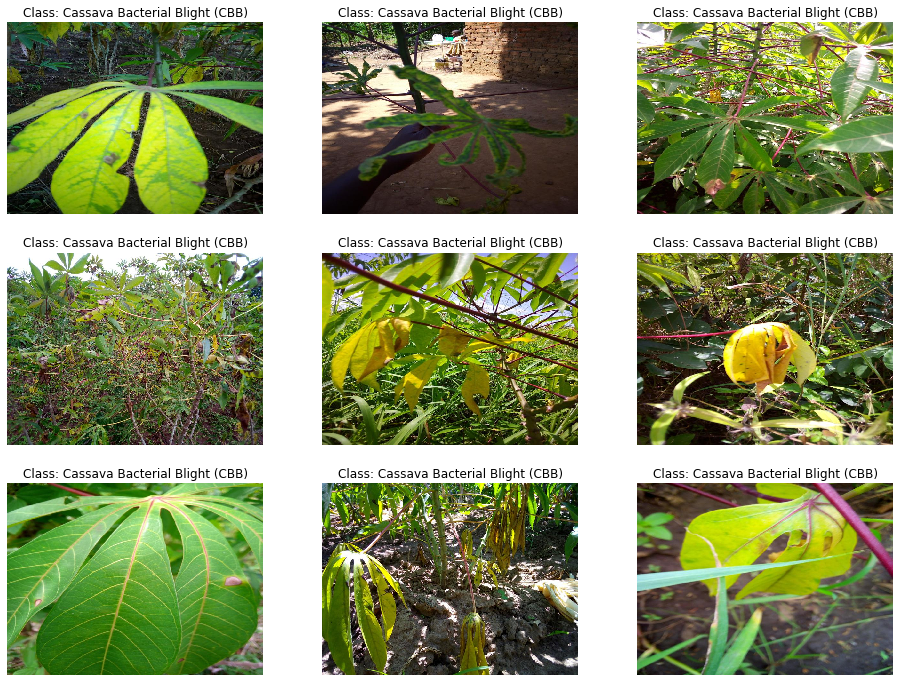

In [59]:
a = data[(data['label']== 0) & (data['label']!=data['predict_label'])]
image_ids = a["image_id"].values
labels = a["disease_name"].values

visualize_batch(image_ids[0:9], labels[0:9])

In [61]:
for i in range(0,5):
    print('■label{} accuracy'.format(i))
    print(data[(data['label']==data['predict_label']) & (data['predict_label']==i)].shape[0]/ data[data['label']==i].shape[0])

■label0 accuracy
0.6359447004608295
■label1 accuracy
0.8100686498855835
■label2 accuracy
0.7782426778242678
■label3 accuracy
0.9707446808510638
■label4 accuracy
0.7650485436893204


# Denoising Data

In [124]:
threshold = 0.80

In [125]:
np.max(output_descriptor, axis=1)

array([0.9929565 , 0.8361465 , 0.9990546 , ..., 0.9594301 , 0.87473726,
       0.74428487], dtype=float32)

In [126]:
one_fold = valid_.copy()
one_fold['disease_name'] = one_fold['label'].apply(lambda x: disease_names[str(x)])
one_fold['predict_label'] = pd.DataFrame(np.argmax(val_preds, axis=1))
one_fold['value'] = np.max(output_descriptor, axis=1)
one_fold.head()

image_id  label  kfold                  disease_name  predict_label  \
0  1000812911.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3   
1  1003298598.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3   
2  1004105566.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3   
3   100472565.jpg      2    4.0    Cassava Green Mottle (CGM)              2   
4   100533489.jpg      2    4.0    Cassava Green Mottle (CGM)              2   

      value  
0  0.992957  
1  0.836146  
2  0.999055  
3  0.942421  
4  0.483931

In [127]:
mask1 = (one_fold["label"] != one_fold["predict_label"]) & (one_fold["value"] >= threshold)
one_list = one_fold[mask1].index.to_list()
print(len(one_list))

89


In [131]:
one_fold.iloc[one_list]

image_id  label  kfold                         disease_name  \
156   1138645276.jpg      4    4.0                              Healthy   
176   1153882793.jpg      1    4.0  Cassava Brown Streak Disease (CBSD)   
208   1179913576.jpg      0    4.0       Cassava Bacterial Blight (CBB)   
211   1182451935.jpg      3    4.0         Cassava Mosaic Disease (CMD)   
218   1184986094.jpg      2    4.0           Cassava Green Mottle (CGM)   
...              ...    ...    ...                                  ...   
4073   805711898.jpg      2    4.0           Cassava Green Mottle (CGM)   
4134   853854962.jpg      1    4.0  Cassava Brown Streak Disease (CBSD)   
4197   916448505.jpg      0    4.0       Cassava Bacterial Blight (CBB)   
4201   920600492.jpg      2    4.0           Cassava Green Mottle (CGM)   
4208   926848319.jpg      0    4.0       Cassava Bacterial Blight (CBB)   

      predict_label     value  
156               3  0.981229  
176               4  0.809540  
208               3  0.801377  
211               1  0.835411  
218               3  0.999993  
...             ...       ...  
4073              4  0.837569  
4134              4  0.880737  
4197              1  0.831586  
4201              3  0.869586  
4208              1  0.809265  

[89 rows x 6 columns]

In [134]:
a = one_fold.iloc[one_list]
print(a.shape[0])
print(a[a['label']==0].shape[0])
print(a[a['label']==4].shape[0])
a[a['label']==4]

89
10
26


image_id  label  kfold disease_name  predict_label     value
156   1138645276.jpg      4    4.0      Healthy              3  0.981229
401   1341694459.jpg      4    4.0      Healthy              3  0.872017
446   1365612235.jpg      4    4.0      Healthy              3  0.976056
466   1385808202.jpg      4    4.0      Healthy              3  0.864920
469   1386736977.jpg      4    4.0      Healthy              3  0.832267
470   1386911368.jpg      4    4.0      Healthy              0  0.945366
479   1395866975.jpg      4    4.0      Healthy              1  0.912206
686   1562043567.jpg      4    4.0      Healthy              0  0.889332
948   1807049681.jpg      4    4.0      Healthy              2  0.850492
1046  1891755915.jpg      4    4.0      Healthy              3  0.900578
1065  1903950320.jpg      4    4.0      Healthy              3  0.931717
1125  1954353329.jpg      4    4.0      Healthy              3  0.893779
1217  2033648478.jpg      4    4.0      Healthy              3  0.929948
1339  2154826831.jpg      4    4.0      Healthy              3  0.892619
1557  2329257679.jpg      4    4.0      Healthy              0  0.924597
1635  2406398124.jpg      4    4.0      Healthy              1  0.837302
1993  2715221153.jpg      4    4.0      Healthy              3  0.999759
2056  2793573567.jpg      4    4.0      Healthy              0  0.816415
2473  3172927521.jpg      4    4.0      Healthy              2  0.808291
2707  3370597486.jpg      4    4.0      Healthy              3  0.896123
2775  3441418915.jpg      4    4.0      Healthy              0  0.887824
2888   354756762.jpg      4    4.0      Healthy              3  0.861495
2945  3601095535.jpg      4    4.0      Healthy              3  0.834547
3187  3831055532.jpg      4    4.0      Healthy              0  0.825862
3707   478546048.jpg      4    4.0      Healthy              2  0.923591
3796   547866885.jpg      4    4.0      Healthy              0  0.837065

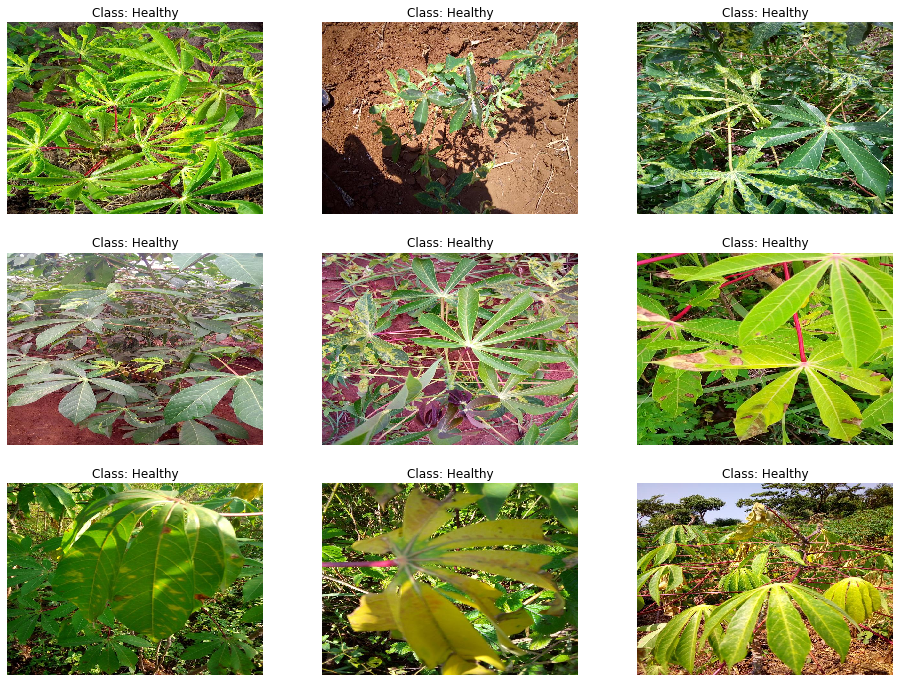

In [136]:
i=4
image_ids = a[a['label']==i]["image_id"].values
labels = a[a['label']==i]["disease_name"].values

visualize_batch(image_ids[0:9], labels[0:9])

## TSNE

In [30]:
from sklearn.manifold import TSNE

st_time = time.time()
t_sne = TSNE(random_state=2020)
t_sne_tr = t_sne.fit_transform(output_descriptor)
print('TNSE done; Time take {} seconds'.format(time.time()-st_time))

TNSE done; Time take 7.288504123687744 seconds


In [31]:
import json
#maping the class labels mentioned in json file wiht its respective disease name
disease_names = open('../input/cassava-leaf-disease-classification/'+'label_num_to_disease_map.json')
disease_names = json.load(disease_names)
disease_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [32]:
tsne_tr = pd.DataFrame()
for idx in range(t_sne_tr.shape[1]):
    tsne_tr['t_sne'+str(idx+1)] = t_sne_tr[:,idx]
tsne_tr['label'] = output_label.astype(int)
tsne_tr['disease_name'] = tsne_tr['label'].apply(lambda x: disease_names[str(x)])
tsne_tr.head()

t_sne1     t_sne2  label                  disease_name
0 -71.249809 -15.214400      3  Cassava Mosaic Disease (CMD)
1  56.942543   6.722906      3  Cassava Mosaic Disease (CMD)
2 -12.862866 -72.879799      3  Cassava Mosaic Disease (CMD)
3  -1.766132  86.453369      2    Cassava Green Mottle (CGM)
4  -4.422757  41.258308      2    Cassava Green Mottle (CGM)

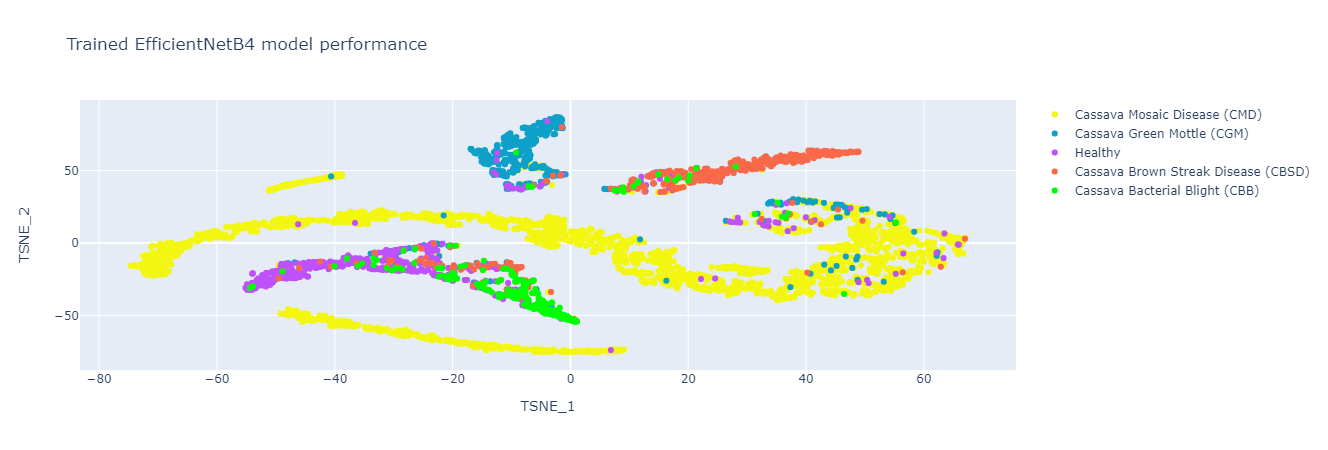

In [33]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,dn in enumerate(tsne_tr['disease_name'].unique()):
    df = tsne_tr[tsne_tr['disease_name'] == dn]
    fig.add_trace(go.Scatter(x=df['t_sne1'],y=df['t_sne2'],mode='markers',marker_color = colors[idx],name=dn))
fig.update_layout(title='Trained EfficientNetB4 model performance')
fig.update_xaxes(title_text="TSNE_1")
fig.update_yaxes(title_text="TSNE_2")
fig.show()

In [62]:
print(disease_names)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
